In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import os

## Read in data from loops

directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/Corrected_Data_Official/nesscanResult_removedBadNesdisRecords/RockPort'
dataframes = []


for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):

        file_path = os.path.join(directory_path, filename)
        
        df = pd.read_csv(
        file_path,
        parse_dates=[0],
        na_values=[-999, -99, 99, 'NA', 'RM'],
        engine='python'   
        )
        df.columns = ['station #','date', 'pwl',]
        dataframes.append(df)

rp = pd.concat(dataframes, ignore_index=True)

directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/data 2/NOAA/rockport'
dataframes = []

# Loop through the files in the directory
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('level.csv'):

        file_path = os.path.join(directory_path, filename)
        
        
        df = pd.read_csv(file_path)
        
        dataframes.append(df)

#formats the dataframes
rp_NOAA = pd.concat(dataframes, ignore_index=True)
rp_NOAA.drop(labels=range(0,3), axis = 0,inplace=True)
rp_NOAA.reset_index(drop = True, inplace=True)
rp['date'] = pd.to_datetime(rp['date'])
rp_NOAA['date'] = pd.to_datetime(rp_NOAA['Date Time'],errors='coerce')
rp = rp.merge(rp_NOAA,on='date',how='outer')
rp.drop(labels=range(0,2), axis = 0,inplace=True)
rp.reset_index(drop = True, inplace=True)
rp['offset'] = rp['pwl'] - rp[' Water Level']
rp = rp.drop(columns='Date Time', axis= 0)
rp = rp.drop(columns=' Sigma', axis= 0)
rp = rp.drop(columns=' O or I (for verified)', axis= 0)
rp = rp.drop(columns=' F', axis= 0)
rp = rp.drop(columns=' R', axis= 0)
rp = rp.drop(columns=' L', axis= 0)
rp = rp.drop(columns=' Quality ', axis= 0)

In [2]:
offset = pd.DataFrame()
offset['values'] = rp['offset']
offset['date'] = rp['date']
offset.replace(0, pd.NA, inplace=True)
offset = offset.dropna()
offset['change'] = (offset['values'] != offset['values'].shift()).cumsum()

result = offset.groupby('change').agg(
    start_index=('change', 'idxmin'),
    end_index=('change', 'idxmax'),
    start_date = ('date','first'),
    end_date = ('date','last'),
    length=('values', 'size'),
    value=('values', 'first')
).reset_index(drop=True)

# Drop the helper column if necessary
offset = offset.drop(columns=['change'])

result = result[result['length']>=10]

result.to_clipboard()

In [3]:
rp[2366330:2366337]

,station #,date,pwl,Water Level,offset
2366330,015,2018-06-15 19:36:00,8.327,2.081,6.246
2366331,015,2018-06-15 19:42:00,8.329,2.083,6.246
2366332,015,2018-06-15 19:48:00,8.324,2.078,6.246
2366333,015,2018-06-15 19:54:00,8.324,2.078,6.246
2366334,015,2018-06-15 20:00:00,8.328,2.082,6.246
2366335,015,2018-06-15 20:06:00,8.335,2.089,6.246
2366336,015,2018-06-15 20:12:00,8.338,2.092,6.246


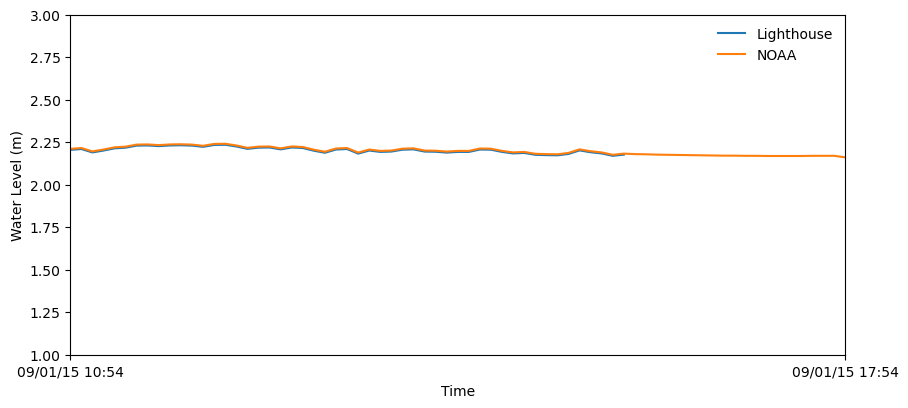

In [21]:

start_date = pd.to_datetime('9/1/15 10:54')
end_date = pd.to_datetime('9/1/15 17:54')

# Filter the data to only include the xlim range
filtered_data = rp[(rp['date'] >= start_date) & (rp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='Lighthouse')
plt.plot(filtered_data['date'], filtered_data[' Water Level'], label='NOAA')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=6500))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(1,3)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()